# Business case:
### We need to create a model which can classify the three major attacking diseases of rice plants like leaf blast, bacterial blight and brown spot.

## Domain Analysis:

This dataset contains 120 jpg images of disease-infected rice leaves. The images are grouped into 3
classes based on the type of disease. There are 40 images in each class.

Classes:
* Leaf smut :leaf smuf is a minor fungal diseases.It is widespread where rice is grown, but leaf smut doesn’t often cause serious damage and In most situations, there is no major loss caused by rice leaf smut, so treatment isn’t usually given.

* Brown spot: Brown spot is the most common and damaging rice diseases.This fungal disease that infects the coleoptile,leaves,leaf sheath and panicle branches etc.it can survive in the seed for more than four years and can spread from plant to plant through air and can occur at all crop stages.it can cause significant yield losses and economic damage to farmers.

* Bacterial leaf blight : Bacterial blight is the most serious diseases of rice.Bacterial blight is caused by Xanthomonas oryzae pv. oryzae. it is commonly observed when strong winds and continuous heavy rain occur.This becteria infected leaves turn into grayish green and roll up.Bacterial leaf blight can cause significant yield losses and economic damage to farmers.

In [3]:
# Import All the required Libraries
import tensorflow as tf
from tensorflow.keras import models, layers
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from os import listdir
import cv2
from keras.models import Sequential

import matplotlib.pyplot as plt

In [4]:
# Assign the value to the variable
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [5]:
# Used the image_dataset_from_directory to load all image in tensorflow dataset.
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "rice_leaf_folder",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 119 files belonging to 4 classes.


In [6]:
#checked the labels in dataset
class_names = dataset.class_names
class_names

['Bacterial leaf blight', 'Brown spot', 'Leaf smut', 'models']

In [7]:
for image_batch, labels_batch in dataset.take(1):  # we checked one sample in image batch and labels batch  
    print(image_batch.shape)         #print the shape in image_batch
    print(labels_batch.numpy())      #checked all the labels batch into array value

(32, 256, 256, 3)
[0 1 2 2 1 0 1 0 1 1 1 2 0 1 0 1 1 1 0 0 2 2 1 2 1 1 1 2 0 2 0 0]


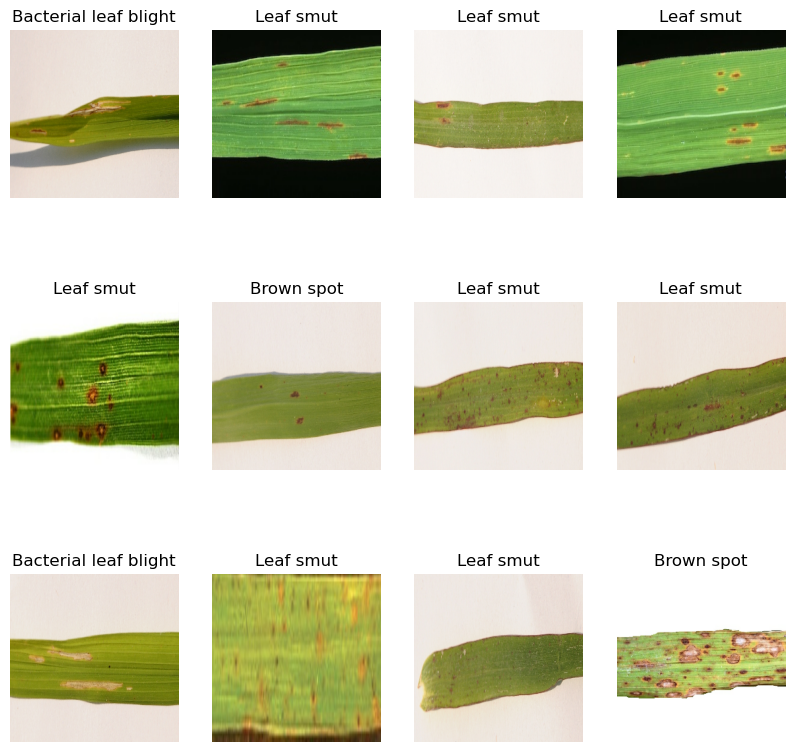

In [8]:
# Visualizing the all image batch with label batch using the foor loop
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
# Check the length of dataset
len(dataset)

4

In [10]:
# split the dataset into training and testing
def get_dataset_partitions_tf(ds, train_split=0.8,test_split=0.2, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split) == 1  # the sum of the split ratios should equal 1.
    
    ds_size = len(ds)   # checked the len of dataset 
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)  
    test_size = int(test_split * ds_size)
    
    train_ds = ds.take(train_size)    
    test_ds = ds.skip(train_size)
    
    return train_ds, test_ds

In [11]:
train_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
len(train_ds)

3

In [13]:
len(test_ds)

1

In [14]:
# Using cache,shuffle and prefetch we are impoving the efficiency and performance of data during model training and evaluation in training and testing dataset.  
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
#resized all the input image in same dimensions
# Rescaled all the pixel image range on 0 to 1.
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [16]:
#used the data augmentation technique such as fliping which randomly flips the images horizontal or vertical 
# rotation ,which randomly rotate the images by certain angle and model will learn ratation invariant features
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
#applying data augmentation to the training dataset 
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)  # X=images,y=Labels

## Define the Model Architecture

In [18]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [19]:
# checked the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

## Compile the model

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

## Train The Model

In [22]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=test_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
3/3 [==============================] - 7s 2s/step - loss: 0.6625 - accuracy: 0.7356 - val_loss: 0.6778 - val_accuracy: 0.6562
Epoch 2/50
3/3 [==============================] - 7s 2s/step - loss: 0.5812 - accuracy: 0.7701 - val_loss: 0.5198 - val_accuracy: 0.8438
Epoch 3/50
3/3 [==============================] - 7s 2s/step - loss: 0.5516 - accuracy: 0.7816 - val_loss: 0.4581 - val_accuracy: 0.8438
Epoch 4/50
3/3 [==============================] - 7s 3s/step - loss: 0.5038 - accuracy: 0.8161 - val_loss: 0.5343 - val_accuracy: 0.8750
Epoch 5/50
3/3 [==============================] - 8s 2s/step - loss: 0.4865 - accuracy: 0.7931 - val_loss: 0.4860 - val_accuracy: 0.7188
Epoch 6/50
3/3 [==============================] - 8s 2s/step - loss: 0.6780 - accuracy: 0.7011 - val_loss: 0.5413 - val_accuracy: 0.8438
Epoch 7/50
3/3 [==============================] - 7s 2s/step - loss: 0.4880 - accuracy: 0.8161 - val_loss: 0.4970 - val_accuracy: 0.8438
Epoch 8/50
3/3 [=========================

In [92]:
scores = model.evaluate(test_ds)

1/1 [==============================] - 0s 354ms/step - loss: 0.2116 - accuracy: 0.9062


In [94]:
# checked the max scores
max(scores)

0.90625

In [95]:
history

In [96]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 3}

In [97]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [98]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

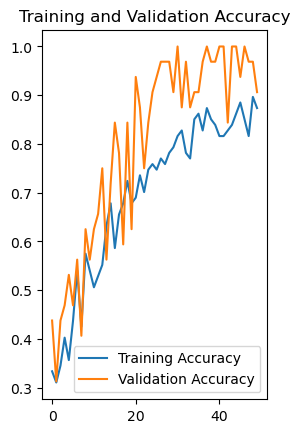

In [99]:
# Analyzed the training accuracy and validation accuracy
#plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()


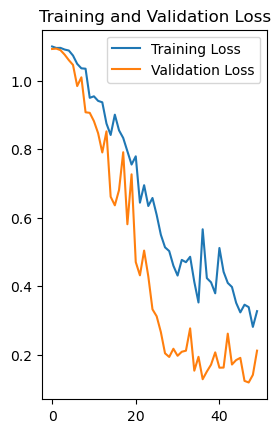

In [100]:
# Analyzed the training loss and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Brown spot
1/1 [==============================] - 0s 455ms/step
predicted label: Brown spot


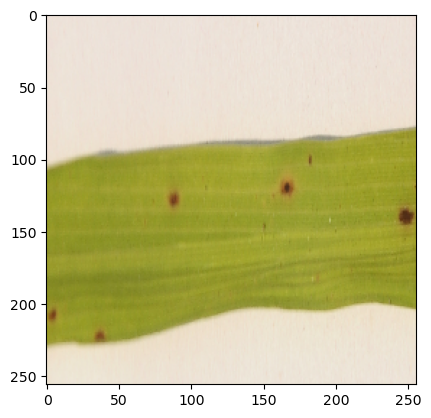

In [71]:
# Visualized the images
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    print("first image to predict")    # Extract the first image from image batch
    plt.imshow(first_image)  # show first image
    print("actual label:",class_names[labels_batch[0].numpy()])  # Actual label
    
    batch_prediction = model.predict(images_batch)  # Predict the images
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])  # Predict the first image labels

In [72]:
# Predict the model 
def predict(model, img): 
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())  # Image converted into array
    img_array = tf.expand_dims(img_array, 0)  # array image expand with dimension

    predictions = model.predict(img_array)  # Predict on image array 

    predicted_class = class_names[np.argmax(predictions[0])]  # predict class of the index with high probability and store in prediction class variable
    confidence = round(100 * (np.max(predictions[0])), 2)   # maximum probability multiplay by 100 and rounded to two decimal.
    return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


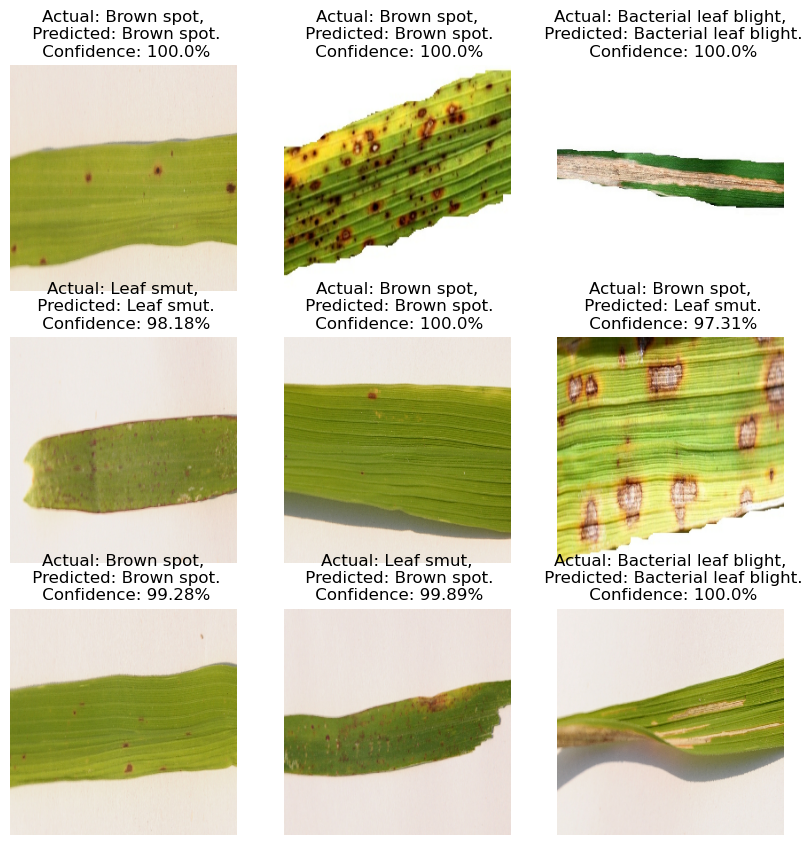

In [75]:
# Visualized the image batch and label batchs
plt.figure(figsize=(10,10))  
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Data Analysis Report

## Challenge faced during the project

## Model save